# Info
Purpose:

    To build and analyse retrieval of aerosol layer heigth from oxygen-A band, using MYSTIC libradtran calculations

Input:

    None

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - Run_libradtran

Needed Files:
  - libradtran input and output files separately built.

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-03-22
    Modified:


# Prepare python environment

In [21]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import Run_libradtran as RL

In [35]:
name = 'aero_oxa'
vv = 'v1_mystic_sunp'
fp = getpath(name)


Return path named:  aero_oxa /data/sam/aero_oxa/


In [25]:
#fp = '/data/sam/ORACLES/'
fp_rtm = '/scratch/rtm/'
fp_uvspec = '/home/sam/libradtran/libRadtran-2.0.2/bin/uvspec'
fp_rtmdat = '/scratch/rtm/dat/' #'/u/sleblan2/4STAR/rtm_dat/'

# Setup defaults

In [26]:
sza = 11.0

In [29]:
aero = lu.load_from_json(getpath('ORACLES')+'aero_file_v4.txt')
aero['ext'] = aero['ext']*0.5/aero['ext'][0,3]

Return path named:  ORACLES /data/sam/ORACLES/


In [85]:
geo = {'lat':-0.576265,
       'lon': 6.639029,
       'doy':225,
       'zout':[0.2,1.0,100.0]}
#aero = {'z_arr':[2.0,5.0],
#        'ext':np.array([[0.6,0.4,0.10,0.04],[0.0,0.0,0.0,0.0]]),
#        'ssa':np.array([[0.8,0.85,0.9,0.95],[0.9,0.9,0.9,0.9]]),
#        'asy':np.array([[0.8,0.8,0.8,0.8],[0.8,0.8,0.8,0.8]]),
#        'wvl_arr':[400.0,500.0,650.0,940.0],
#        'disort_phase':False,
#        'expand_hg':True}
source = {'wvl_range':[750,775],
          'source':'solar',
          'integrate_values':False,
          'run_fuliou':False,
          'dat_path':'/home/sam/libradtran/libRadtran-2.0.2/data/',
          'atm_file':fp_rtmdat+'atmos_20170815.dat',
          'zenith':False,
          'umu':np.cos(np.arange(sza-3.0,sza+3.0+1)*np.pi/180.0)*-1.0}
albedo = {'create_albedo_file':False,
          'sea_surface_albedo':False,
          'alb':0.0382}

In [75]:
RL.print_version_details(fp+'aero_oxa_%s.txt'%vv,vv,geo=geo,
                         aero=aero,cloud=None,source=source,albedo=albedo,
                         tau=None,ref=None,sza=sza)

In [37]:
fp_in = os.path.join(fp_rtm,'input','%s'%vv)
fp_out = os.path.join(fp_rtm,'output','%s'%vv)

In [39]:
f_slit_vis = os.path.join(fp_rtmdat,'4STAR_vis_slit_1nm.dat')
f_slit_nir = os.path.join(fp_rtmdat,'4STAR_nir_slit_1nm.dat')

In [62]:
zs = np.arange(0.2,4.2,0.2)
z_arrs = np.array([zs.T,zs.T+3.0]).T
nz = len(z_arrs)

In [65]:
z_arrs, nz

(array([[0.2, 3.2],
        [0.4, 3.4],
        [0.6, 3.6],
        [0.8, 3.8],
        [1. , 4. ],
        [1.2, 4.2],
        [1.4, 4.4],
        [1.6, 4.6],
        [1.8, 4.8],
        [2. , 5. ],
        [2.2, 5.2],
        [2.4, 5.4],
        [2.6, 5.6],
        [2.8, 5.8],
        [3. , 6. ],
        [3.2, 6.2],
        [3.4, 6.4],
        [3.6, 6.6],
        [3.8, 6.8],
        [4. , 7. ]]),
 20)

# Write out input files

In [66]:
if not os.path.exists(fp_in):
    os.makedirs(fp_in)
if not os.path.exists(fp_out):
    os.makedirs(fp_out)

In [69]:
f_list = open(os.path.join(fp_rtm,'input',vv,'{}_list.sh'.format(name)),'w')
print(f_list.name)

/scratch/rtm/input/v1_mystic_sunp/aero_oxa_list.sh


In [76]:
aero['z_arr']
source['slit_file'] = f_slit_vis

[2.0, 5.0]

In [ ]:
for z in z_arrs:
    fname = 'sun_oxa_aod{:02.0f}km.dat'.format(z[0]*10)
    aero['z_arr'] = z
    RL.write_input_aac(os.path.join(fp_in,fname),geo=geo,aero=aero,cloud=None,source=source,albedo=albedo,
                       verbose=False,make_base=False,set_quiet=True)
    f_list.write(fp_uvspec+' < '+os.path.join(fp_in,fname)+' > '+os.path.join(fp_out,fname)+'\n')
    print(fname)

In [77]:
f_list.close()

# Read the output files

In [163]:
n = len(z_arrs)
nz = len(geo['zout'])
wvl = np.arange(source['wvl_range'][0],source['wvl_range'][1]+1)
nw = len(wvl)

In [164]:
umu = source['umu']
numu = len(source['umu'])
zout = geo['zout']

In [165]:
rad = np.zeros((n,nw,nz,numu-1))+np.nan

In [166]:
for i,z in enumerate(z_arrs):
    fname = 'sun_oxa_aod{:02.0f}km.dat'.format(z[0]*10)
    o = RL.read_libradtran(os.path.join(fp_out,fname),zout=geo['zout'],num_rad=numu,use_mystic=True)
    rad[i,:,:,:] = o['rad']

## Save the output

In [122]:
from datetime import datetime 

In [125]:
str(datetime.now())

'2022-03-22 17:12:36.433215'

In [126]:
d = {'wvl':wvl,'umu':umu,'zout':zout,'sza':sza,'rad':rad,'z_arrs':z_arrs,'vv':vv,'created_on':'{}'.format(datetime.now())}

In [130]:
sio.savemat(fp+'{}.mat'.format(vv),d)

# Plot out the radiances

<IPython.core.display.Javascript object>


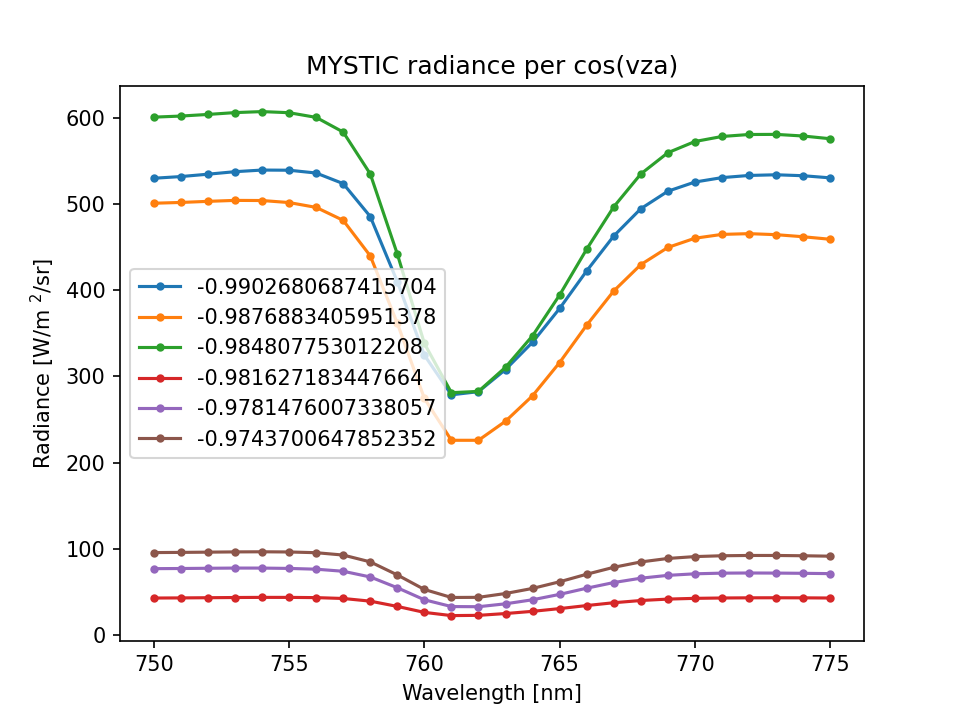

Text(0.5, 1.0, 'MYSTIC radiance per cos(vza)')

In [167]:
plt.figure()
for i in range(numu-1):
    plt.plot(wvl,rad[0,:,0,i],'.-',label='{}'.format(umu[i]))
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Radiance [W/m $^2$/sr]')
plt.title('MYSTIC radiance per cos(vza)')

In [156]:
plt.cm.gist_rainbow(n+1)

(1.0, 0.2829888712241654, 0.0, 1.0)

<IPython.core.display.Javascript object>


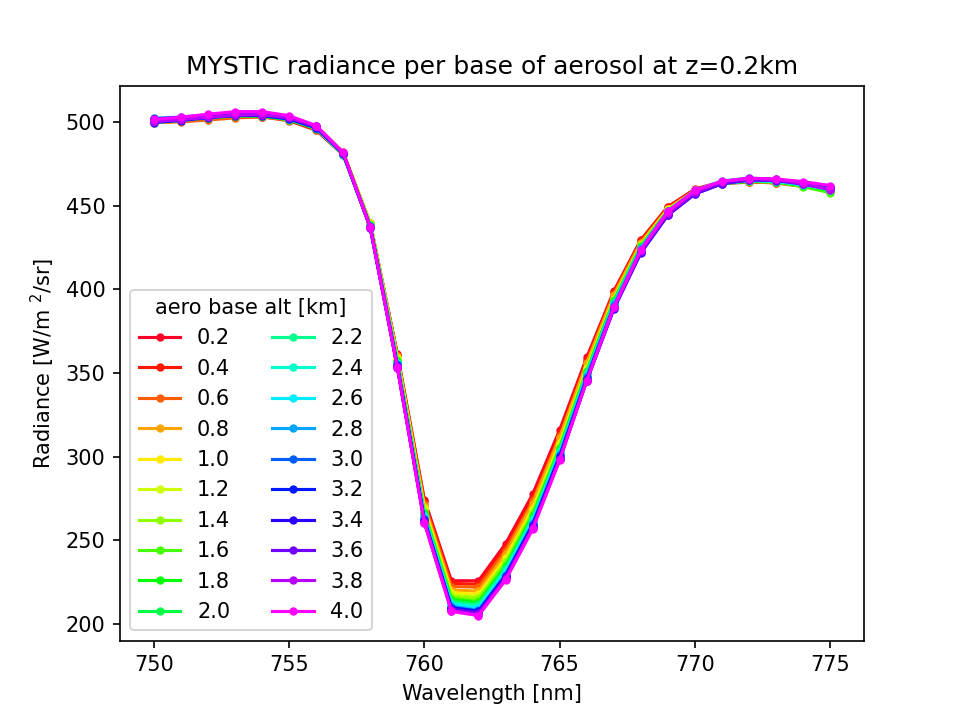

Text(0.5, 1.0, 'MYSTIC radiance per base of aerosol at z=0.2km')

In [172]:
iz = 0
fig,ax = plt.subplots(1)
ax.set_prop_cycle(color=[plt.cm.gist_rainbow(ii) for ii in np.linspace(0,1,n+1)])
for i in range(n):
    plt.plot(wvl,rad[i,:,iz,1],'.-',label='{:01.1f}'.format(z_arrs[i,0]))
plt.legend(title='aero base alt [km]',ncol=2)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Radiance [W/m $^2$/sr]')
plt.title('MYSTIC radiance per base of aerosol at z={:02.1}km'.format(zout[iz]))